In [1]:
import tifffile
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pyvista as pv
import cv2 as cv
import numpy as np
import itertools
import scipy
import time
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
from skimage.segmentation import mark_boundaries, slic
from scipy.ndimage import generic_filter
from cv2 import fastNlMeansDenoising,fastNlMeansDenoisingMulti, medianBlur
from skimage import morphology
from skimage.measure import regionprops
import pyvista
from scipy.linalg import orthogonal_procrustes
import math

In [2]:
path1 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//low_resolution//GMM_3D//Mask_corss_segmentation_low_res.tif'
low_res = tifffile.imread(path1)
path2 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//high_resolution//GMM_3D//Mask_corss_segmentation_high_res.tif'
high_res = tifffile.imread(path2)

print ('Low Resolution shape is ',low_res.shape)
print ('High Resolution shape is ',high_res.shape)



Low Resolution shape is  (62, 132, 85)
High Resolution shape is  (663, 1206, 770)


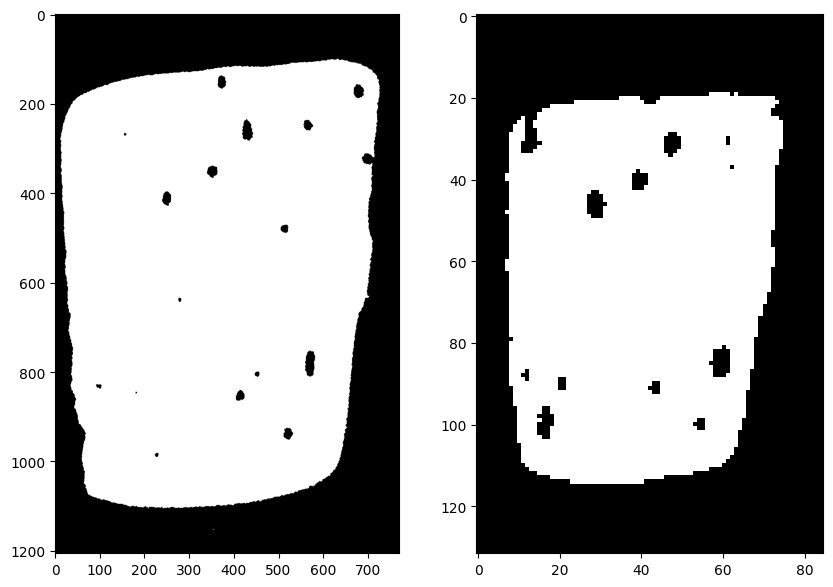

In [3]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(high_res[45],'gray')

fig.add_subplot(1, 2, 2)
plt.imshow(low_res[1], 'gray')


In [4]:
def extract_properties (regions):
    properties = pd.DataFrame(columns= ['area','area_bbox','area_convex','area_filled','axis_major_length',
                                       'axis_minor_length','bbox','centroid','coords','equivalent_diameter_area',
                                       'euler_number', 'extent','inertia_tensor','solidity','label',
                                        'transformed_coord','matched_high_centroid',
                                        'matched_high_label', 'distance_transformed_high_res'])
    
    for c in properties.columns:
        
        _vals = []
        for r in regions:
            try:
                val = eval('r.{}'.format(c))
                
            except:
                val = 0
                
            _vals.append(val)
        code = 'properties.{} = _vals'.format(c)
        exec(code)

    return properties

    

In [ ]:
# Getting labels and regions
labelled_low_res = morphology.label(low_res, connectivity=2, background=1)
regions_low_res = regionprops(labelled_low_res)

labelled_high_res = morphology.label(high_res, connectivity=2, background=1)
regions_high_res = regionprops(labelled_high_res)

# properties data frame (pdf)
pdf_low =extract_properties(regions_low_res)
pdf_high =extract_properties(regions_high_res).drop(columns = ['transformed_coord','matched_high_centroid', 
                                                               'matched_high_label','distance_transformed_high_res'])

In [6]:
def draw_rectangules (labelled_image, regions, fontScale):
    img = (labelled_image * 1000)/ labelled_image.max()
    img = img.astype('uint8')
    
    for r in regions[2:]:
        
        for layer in range (r.bbox[0], r.bbox[3]):
            text = '{}'.format(r.label)
            org = ( r.bbox[5],r.bbox[-2])
            font = cv.FONT_HERSHEY_COMPLEX_SMALL
            img[layer] = cv.putText(img[layer],text,org,font,fontScale,200)
            
    return img


In [7]:
Recs_low_res = draw_rectangules (low_res, regions_low_res,fontScale = 0.7)
Recs_high_res = draw_rectangules (high_res, regions_high_res,fontScale = 2)

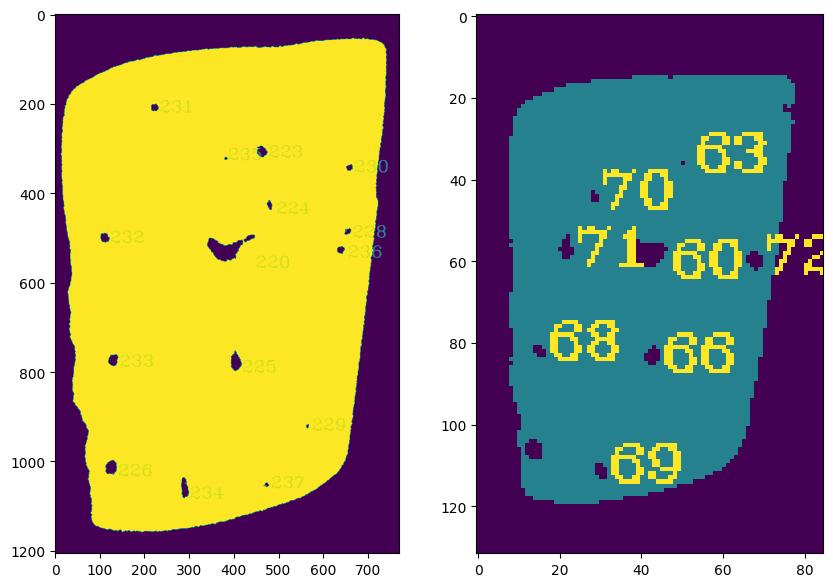

In [8]:
# finding matching points in both volumes
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(Recs_high_res[252])

fig.add_subplot(1, 2, 2)
plt.imshow(Recs_low_res[22])

In [9]:
# finding coresponding regions matching by label manually:
# for obtaining following matches I used these layers (high_res, low_res):
# [ (46,0) , (54,1), (170, 12), (252, 22)]
# Matched regions (Mrg)

#First version
#Mrg_high_res = [42, 47, 46, 54, 56, 42, 69, 72, 55, 61, 54, 46, 321, 325, 374, 384, 578, 592, 518, 515, 520, 525]
#Mrg_low_res  = [12, 4 , 3 , 5 , 8 , 12, 17, 12, 9 , 6 , 5 , 3 , 112, 115, 126, 128, 186, 190, 170, 172, 171, 173]

# Edited (points with high error are removed)
#Mrg_high_res = [42, 47, 46, 54, 42, 69, 55, 61, 54, 46, 321, 325, 374, 384, 578, 592, 518, 515, 520, 525]
#Mrg_low_res  = [12, 4 , 3 , 5 , 12, 17, 9 , 6 , 5 , 3 , 112, 115, 126, 128, 186, 190, 170, 172, 171, 173]

Mrg_high_res = [42, 47, 46, 55, 54, 171, 166, 167, 220, 225, 234, 234]
Mrg_low_res  = [11, 4 , 3 , 8 , 5 , 48 , 45 , 44 , 60 , 66 , 69 , 69 ]




In [10]:
def find_transformation_matrix (regions_high_res, regions_low_res, Mrg_high_res, Mrg_low_res, scale):
    
    def get_centroids_by_labels(regions, labels):
        centroids = []
        for l in labels:
            for r in regions:
                if r.label == l:
                    centroids.append(r.centroid)
            
        return centroids

    
    Mrg_centroid_high_res = get_centroids_by_labels (regions=regions_high_res, labels=Mrg_high_res)
   
    Mrg_centroid_high_res = np.array(Mrg_centroid_high_res, dtype= 'float32') 
    print ('shape of given high res ',Mrg_centroid_high_res.shape)
    
    Mrg_centroid_low_res = get_centroids_by_labels (regions=regions_low_res, labels=Mrg_low_res)
    Mrg_centroid_low_res = np.array(Mrg_centroid_low_res, dtype= 'float32') * scale
    print ('shape of given low res ', Mrg_centroid_low_res.shape)
    
    
    a = Mrg_centroid_low_res.mean(axis=0, keepdims=True)
    b = Mrg_centroid_high_res.mean(axis=0, keepdims=True)
    # Compute the transformation matrix
    T, s = orthogonal_procrustes((Mrg_centroid_low_res - a),
                                 (Mrg_centroid_high_res - b ))
    # check the error of transformation matrix
    
    
    transformed = ((Mrg_centroid_low_res - a) @ T) + b
        
    errors = Mrg_centroid_high_res - transformed
    print ('MAE = ', np.abs(errors).mean())
    print (errors.astype('int'))
    return T,a,b,s, errors, transformed,Mrg_centroid_high_res
    
    

In [11]:
# scale obtained from CT scan machine parameters
scale = 9.887
affine_matrix,a,b,s, errors, transformed_train,Mrg_centroid_high_res_train = find_transformation_matrix (regions_high_res, regions_low_res, Mrg_high_res, Mrg_low_res, scale = scale)

shape of given high res  (12, 3)
shape of given low res  (12, 3)
MAE =  1.7972997
[[-2  1  0]
 [ 0  2  1]
 [-3 -1  0]
 [ 3 -1  3]
 [-2  2  0]
 [ 2  0  0]
 [ 2  2  0]
 [ 1 -2 -1]
 [ 2 -1 -1]
 [ 2  1 -1]
 [-3 -1  0]
 [-3 -1  0]]


In [12]:
def find_nearest_coresponding_center (transformed, centriods_high_res, labels_high_res):
    # length of transformed must be less than centriods_high_res
    def get_distance (pnt, centers):
        min_dist = 100000 #starting with very high number
        for i in range (centers.shape[0]):
            dist = np.linalg.norm(pnt-centers[i])
            if dist < min_dist:
                index = i
                min_dist = dist
        return index, min_dist
    
    nearest_centers = []
    coresponding_labels = []
    dists = []
    for pnt in transformed:
        nearest, min_dist = get_distance(pnt, centriods_high_res)
        nearest_centers.append(centriods_high_res [nearest])
        coresponding_labels.append(labels_high_res[nearest])
        dists.append(min_dist)
        
    return nearest_centers,coresponding_labels,dists

In [13]:
# transforming the points with the developed affine 
pdf_low.transformed_coord = list((((np.array(list(pdf_low.centroid))*scale) -a ) @ affine_matrix) + b)

pdf_low.matched_high_centroid, pdf_low.matched_high_label,pdf_low.distance_transformed_high_res= find_nearest_coresponding_center (pdf_low.transformed_coord,
                                                                        pdf_high.centroid, pdf_high.label)
merged = pdf_low.merge(pdf_high, left_on='matched_high_label', right_on='label')


In [14]:
#calculating the volume of 
resolution_low = 116.444625
resolution_high = 11.777969

volume_low = np.array(merged['area_x']) * resolution_low**3
merged['volume_low'] = [round(v) for v in volume_low]

volume_high = np.array(merged['area_y']) * resolution_high**3
merged['volume_high'] = [round(v) for v in volume_high]

In [15]:
#merged.to_excel('buble_validation.xlsx')

In [16]:
# this is for checking if the bubbles in low res and their corresponding high res are selected correctly 
num = 50
bubble_high = merged.coords_y[num]
#transforming the low res bubble
bubble_low_transofrmed = (((merged.coords_x[num]*scale) -a ) @ affine_matrix) + b

# Define the points that make up the mesh
points1 = bubble_low_transofrmed
points2 = bubble_high
# Create a PyVista.PolyData object from the points
poly_data1 = pv.PolyData(points1)
poly_data2 = pv.PolyData(points2)

# Create a mesh from the point cloud
mesh1 = poly_data1.delaunay_3d(alpha=10)
mesh2 = poly_data2.delaunay_3d(alpha=2.)
# Create a plotter to display the mesh
plotter = pv.Plotter(off_screen = True,image_scale = 1)
plotter.add_mesh(mesh1, color='red', opacity=0.5, label = 'Low-Res')
plotter.add_mesh(mesh2, color='blue', opacity=0.5, label = 'High-Res')
plotter.view_isometric()
plotter.show_grid()
#plotter.add_legend(bcolor='w', face='r')
plotter.show()

C:\Users\Fabagh001\Anaconda3\envs\FARAMARZ\lib\site-packages\pyvista\utilities\helpers.py:507: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value="<iframe src='http://localhost:55716/index.html?ui=P_0x1ebb1715de0_0&reconnect=auto' style='width…

In [17]:
merged.head(3)

,area_x,area_bbox_x,area_convex_x,area_filled_x,axis_major_length_x,axis_minor_length_x,bbox_x,centroid_x,coords_x,equivalent_diameter_area_x,...,centroid_y,coords_y,equivalent_diameter_area_y,euler_number_y,extent_y,inertia_tensor_y,solidity_y,label_y,volume_low,volume_high
0,311102,695640,695640,311102,210.421291,81.181370,"(0, 0, 0, 62, 132, 85)","(30.146186781184305, 68.44731309988364, 44.310...","[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [...",84.068776,...,"(366.9086519639828, 621.5979381443299, 421.917...","[[354, 623, 425], [354, 623, 426], [354, 624, ...",30.818398,3,0.413367,"[[133.52238611420617, 10.27344947135183, -4.71...",0.861447,325,491203149700,25040330
1,57,75,57,57,5.856003,3.443887,"(32, 66, 43, 35, 71, 48)","(33.0, 68.0701754385965, 45.36842105263158)","[[32, 66, 45], [32, 66, 46], [32, 67, 44], [32...",4.774839,...,"(366.9086519639828, 621.5979381443299, 421.917...","[[354, 623, 425], [354, 623, 426], [354, 624, ...",30.818398,3,0.413367,"[[133.52238611420617, 10.27344947135183, -4.71...",0.861447,325,89998070,25040330
2,379393,502386,400085,383807,130.238909,78.488430,"(0, 11, 7, 62, 122, 80)","(30.77980352826752, 63.17248868587454, 40.1180...","[[0, 19, 61], [0, 19, 62], [0, 19, 65], [0, 19...",89.818038,...,"(409.58414736254537, 577.0136756907619, 368.98...","[[403, 576, 369], [403, 576, 370], [403, 576, ...",18.985239,1,0.420244,"[[60.17048862161061, -1.4910345462560084, -1.5...",0.825957,373,599028731972,5854072


In [16]:
transformed = (((centriods_low_res*scale) -a ) @ affine_matrix) + b

In [49]:
def show_centers(list_of_points):
    
    def create_spheres (points):
        pdata = pyvista.PolyData(points)
        #pdata['orig_sphere'] = points[:,0]

        # create many spheres from the point cloud
        sphere = pyvista.Sphere(radius=5, phi_resolution=10, theta_resolution=10)
        pc = pdata.glyph(scale=False, geom=sphere, orient=False)
        
        return pc
        
    pl = pyvista.Plotter(notebook = True,lighting = None)  
    sp = create_spheres(list_of_points[0])
    pl.add_mesh(sp, color='red')
    
    sp = create_spheres(list_of_points[1])
    pl.add_mesh(sp, color='blue')
    pl.camera_position = 'yz'
    pl.camera.zoom(1.4)
    pl.show()
    def make_gif():
        screenshots = []
        for i in range(36):
            pl.camera.elevation += 0.5
            pl.camera.azimuth += 4
            pl.show(auto_close=True, return_viewer=False)
            screenshots.append(pl.image)

        imageio.mimsave('sphere.gif', screenshots, fps=3)
        return screenshots



In [50]:
#show_centers([transformed_train,Mrg_centroid_high_res_train])

In [51]:
#show_centers([transformed,centriods_high_res])

In [52]:
def find_nearest_coresponding_center (transformed, centriods_high_res, labels_high_res):
    # length of transformed must be less than centriods_high_res
    def get_distance (pnt, centers):
        min_dist = 100000 #starting with very high number
        for i in range (centers.shape[0]):
            dist = np.linalg.norm(pnt-centers[i])
            if dist < min_dist:
                index = i
                min_dist = dist
        return index
    
    nearest_centers = []
    coresponding_labels = []
    for pnt in transformed:
        nearest = get_distance(pnt, centriods_high_res)
        nearest_centers.append(centriods_high_res [nearest])
        coresponding_labels.append(labels_high_res[nearest])
    
    return nearest_centers,coresponding_labels
        

In [53]:
nearest_centers, coresponding_labels = find_nearest_coresponding_center (transformed, centriods_high_res, labels_high_res)

In [120]:
n = 140
print (nearest_centers[n], coresponding_labels[n])
print (labels_low_res[n])

[601.42406629 733.6026784  380.16844048] 540
143


In [127]:
show_centers([transformed[:], nearest_centers[:]])

Widget(value="<iframe src='http://localhost:53917/index.html?ui=P_0x2a2f1d28100_7&reconnect=auto' style='width…

 JS Error => TypeError: Cannot read properties of null (reading 'wsSubscription')
 JS Error => TypeError: Cannot read properties of null (reading 'wsSubscription')
 JS Error => TypeError: Cannot read properties of null (reading 'wsSubscription')
 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'setSize')
 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'setSize')
 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'setSize')


In [133]:
volumes_high = []
volumes_low = []
_n = 0
for l in coresponding_labels:
    volumes_low.append(regions_low_res[_n].area)
    volumes_high.append(regions_high_res[l-1].area)
    _n +=1
    print (l, _n)
volumes_high = np.array(volumes_high)*(11.777969**3)
volumes_low = np.array(volumes_low)*(116.444625**3)

46 1
47 2
54 3
61 4
39 5
55 6
49 7
51 8
42 9
68 10
62 11
63 12
69 13
74 14
76 15
70 16
72 17
90 18
83 19
101 20
105 21
106 22
110 23
113 24
102 25
103 26
108 27
116 28
125 29
126 30
117 31
118 32
122 33
120 34
171 35
134 36
158 37
155 38
148 39
160 40
156 41
167 42
166 43
176 44
170 45
171 46
180 47
177 48
183 49
182 50
189 51
192 52
188 53
184 54
190 55
207 56
205 57
220 58
209 59
210 60
223 61
224 62
228 63
225 64
228 65
233 66
234 67
238 68
240 69
236 70
242 71
254 72
243 73
257 74
260 75
266 76
273 77
270 78
271 79
276 80
282 81
291 82
296 83
315 84
310 85
307 86
303 87
311 88
314 89
318 90
321 91
319 92
325 93
343 94
357 95
354 96
345 97
363 98
349 99
377 100
373 101
374 102
384 103
391 104
402 105
399 106
408 107
415 108
416 109
435 110
427 111
433 112
436 113
442 114
444 115
449 116
461 117
455 118
458 119
453 120
498 121
471 122
477 123
476 124
487 125
490 126
499 127
498 128
495 129
491 130
493 131
501 132
509 133
507 134
518 135
520 136
515 137
510 138
525 139
531 140
540 141

In [135]:
volumes_high

array([10441912.22676472, 21122366.0252878 , 32513542.99994023,
        3207240.44768255, 10211539.8869159 ])

In [150]:
dif = 2*(volumes_low-volumes_high)/ (volumes_low+volumes_high)
mean_bubble = (volumes_low+volumes_high)/2
dif.mean()

0.5095411875800292

In [209]:
nearest_centers = np.array(nearest_centers)
dists = []
for pnt in nearest_centers - transformed:
    dists.append(math.sqrt(pnt[0]**2 + pnt[1]**2 + pnt[2]**2))
dists = np.array(dists)


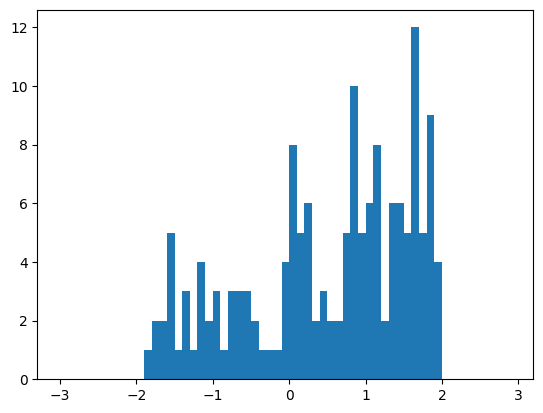

In [219]:
hist = plt.hist(dif,bins = np.array(range(-30,30))/10)

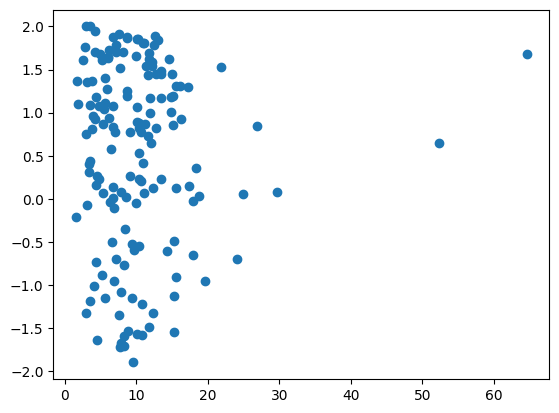

In [217]:
plt.scatter(dists, dif)


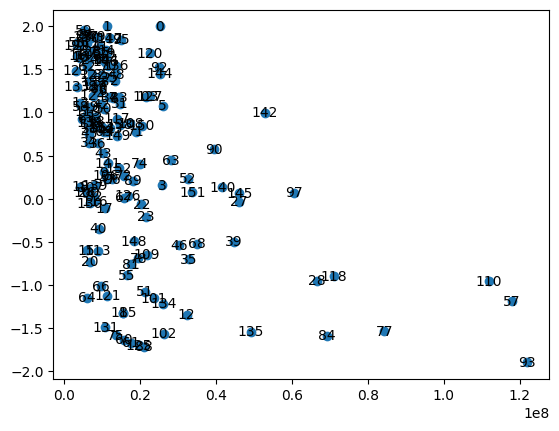

In [176]:
x =volumes_high
y =dif
plt.scatter(x,y)
for i, (x_val, y_val) in enumerate(zip(x, y)):
    plt.text(x_val, y_val, i, ha='center', va='center')

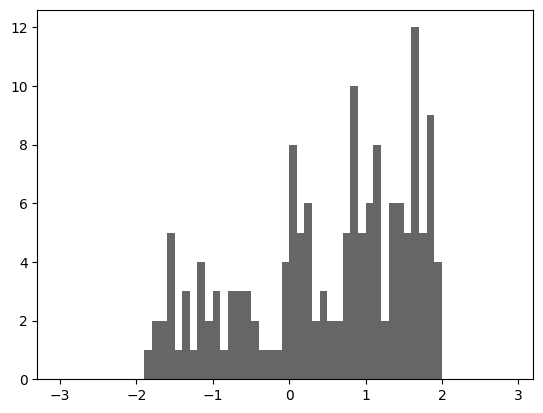

In [148]:
hist1 = plt.hist(dif, bins = np.array(range(-30,30))/10,
                 label = 'High res volume', color = 'black', alpha = 0.6)

In [ ]:
volumes_low-volumes_high

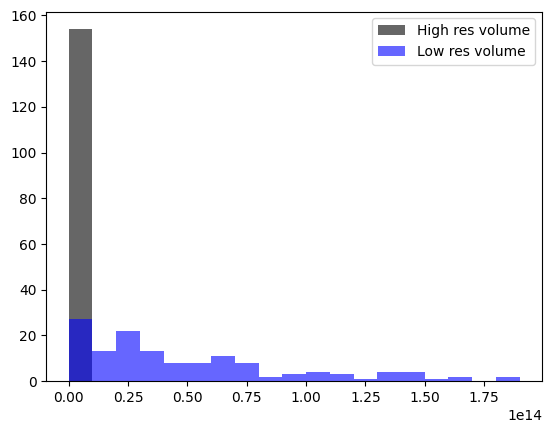

In [140]:
hist1 = plt.hist(volumes_high*(11.777969**3), bins = range(10000, 200000000000000, 10000000000000),
                 label = 'High res volume', color = 'black', alpha = 0.6)
hist2= plt.hist(volumes_low*(116.444625**3),bins = range(10000, 200000000000000, 10000000000000),
                label = 'Low res volume',color = 'blue', alpha = 0.6)

plt.legend()

In [128]:
print ('High res volume = ',round((regions_high_res[539].area)*(11.777969**3)))
print ('Low res volume  = ',round ((regions_low_res[142].area)*(116.444625**3)))

High res volume =  41602630
Low res volume  =  157891351


9044974

In [196]:
bubble_high = regions_high_res[434].coords
bubble_low_transofrmed = (((regions_low_res[109].coords*scale) -a ) @ affine_matrix) + b
# Define the points that make up the mesh
points1 = bubble_low_transofrmed
points2 = bubble_high
# Create a PyVista.PolyData object from the points
poly_data1 = pv.PolyData(points1)
poly_data2 = pv.PolyData(points2)

# Create a mesh from the point cloud
mesh1 = poly_data1.delaunay_3d(alpha=20)
mesh2 = poly_data2.delaunay_3d(alpha=2.)
# Create a plotter to display the mesh
plotter = pv.Plotter(off_screen = True,image_scale = 1)
plotter.add_mesh(mesh1, color='red', opacity=0.5, label = 'Low-Res')
plotter.add_mesh(mesh2, color='blue', opacity=0.5, label = 'High-Res')
plotter.view_isometric()
plotter.show_grid()
#plotter.add_legend(bcolor='w', face='r')
plotter.show()

C:\Users\Fabagh001\Anaconda3\envs\FARAMARZ\lib\site-packages\pyvista\utilities\helpers.py:507: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value="<iframe src='http://localhost:53917/index.html?ui=P_0x2a32ff66ce0_18&reconnect=auto' style='widt…

 JS Error => TypeError: Cannot read properties of null (reading 'wsSubscription')
 JS Error => TypeError: Cannot read properties of null (reading 'wsSubscription')
 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'setSize')
 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'setSize')


[1 2 3]


In [201]:
test[0]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [25]:
def label_on_center(vol, n, regions):
    pixel_coords =np.array(regions[n].centroid)
    pixel_coords = np.round(pixel_coords).astype('int')
    img = vol [pixel_coords[0]]
    img = img*200/img.max()
    img = img.astype('uint8')
    torgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    thickness = 1
    color = (255, 0, 0)
        # Define the text to be written
    text = 'Hello, World!'

    # Define the font type, scale, color, and thickness
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 1

    # Get the size of the text
    (text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)

    # Calculate the coordinates where the text should be written
    x = (img.shape[1] - text_width) // 2
    y = (img.shape[0] + text_height) // 2

    # Write the text on the image
    img = img.astype('uint8')
    cv.putText(img, text, (x, y), font, font_scale, color, thickness)
    return 

In [26]:
def Cross_on_center(vol, n, regions):
    pixel_coords =np.array(regions[n].centroid)
    pixel_coords = np.round(pixel_coords).astype('int')
    img = vol [pixel_coords[0]]
    img = img*200/img.max()
    img = img.astype('uint8')
    torgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    thickness = 1
    color = (255, 0, 0)
    line_length = 3
    cv.line(torgb, (pixel_coords[2]-line_length, pixel_coords[1]),
             (pixel_coords[2]+line_length, pixel_coords[1]), color, thickness)
    cv.line(torgb, (pixel_coords[2], pixel_coords[1]-line_length),
             (pixel_coords[2], pixel_coords[1]+line_length), color, thickness)
    return torgb

In [ ]:
def draw_rectangules (labelled_image, regions, fontScale):
    img = (labelled_image * 1000)/ labelled_image.max()
    img = img.astype('uint8')
    
    for r in regions[2:]:
        
        for layer in range (r.bbox[0], r.bbox[3]):
            text = '{}'.format(r.label)
            org = ( r.bbox[5],r.bbox[-2])
            font = cv.FONT_HERSHEY_COMPLEX_SMALL
            img[layer] = cv.putText(img[layer],text,org,font,fontScale,200)
            
    return img